# Tutorial on Diffraction

In this notebook, you will

- Learn what diffraction is and why it is important
- Make various ray tracing experiments to validate some theoretical results
- Familiarize yourself with the Sionna RT API
- Visualize the impact of diffraction on channel impulse responses and coverage maps

## Table of Contents
* [Background Information](#Background-Information)
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Experiments with a Simple Wedge](#Experiments-with-a-Simple-Wedge)
* [Coverage Maps with Diffraction](#Coverage-Maps-with-Diffraction)
* [References](#References)

## Background Information

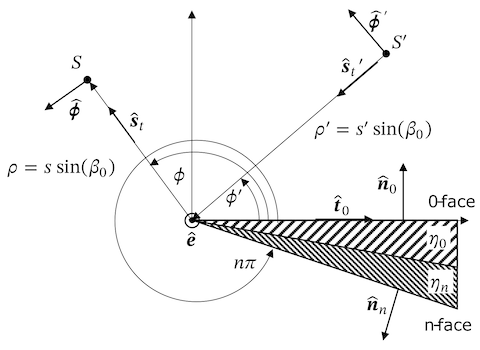


Let's consider an infinitely long wedge as shown in the figure above. To better visualize this, think of an endless slice of pie.
The edge vector is pointed straight out of your screen and the wedge has an opening angle of $n\pi$, where $n$ is a real number between 1 and 2.

The wedge has two faces, the 0- and the n-face. They are labeled this way to indicate from which surface the angle $\phi'\in[0,n]$ of an incoming locally planar electromagnetic wave is measured. Both faces are made from possibly different materials, each with their own unique properties. These properties are represented by a term known as complex relative permittivity, denoted by $\eta_0$ and $\eta_n$, respectively. Without diving too deep into the specifics, permittivity measures how a material reacts to an applied electric field.

We can define three distinct regions in this figure: Region $I$, in which the incident field as well as the reflected field from the 0-face are present,
Region $II$, in which the reflected field vanishes, and Region $III$, in which the incident field is shadowed by the wedge. The three regions are separated by the reflection shadow boundary (RSB) and the incident shadow boundary (ISB). The former is determined by the angle of specular reflection $\pi-\phi'$, while the latter is simply the prolongation of the direction of the incoming wave through the edge, i.e., $\pi+\phi'$.

Using geometrical optics (GO) alone, the electromagnetic field would abruptly change at each boundary as the reflected and incident field components suddenly disappear. As this is physically not plausible, the geometrical theory of diffraction (GTD) [1], as developed by Joseph B. Keller in the 1960s, introduces a so-called diffracted field which ensures that the total field is continuous. The diffracted field is hence especially important in the transition regions between the different regions and then rapidly decays to zero. Most importantly, without diffraction, there would be no field beyond the ISB in Region $III$.

Diffraction is hence a very important phenomenon which enables wireless coverage behind buildings at positions without a line-of-sight of strong reflected path. As you will see later in this tutorial, the diffracted field is generally much weaker than the incident or reflected field. Moreover, the higher the frequency, the faster the diffracted field decays when moving away from the RSB and ISB.

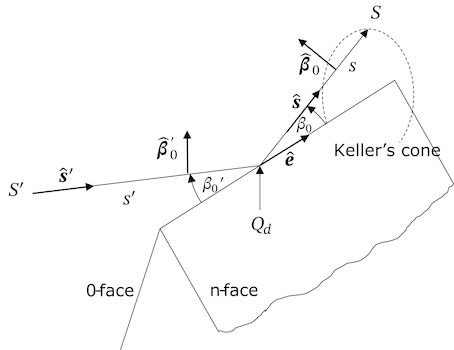


According to the GTD, when a ray hits a point on the edge, its energy gets spread over a continuum of rays lying on the Keller cone. All rays on this cone make equal angles with the edge of diffraction at the point of diffraction, i.e., $\beta_0'=\beta_0$. One can think of this phenomenon as an extension of the law of reflection at planar surfaces. The figures above illustrates this concept.

The GTD was later extended to the uniform theory of diffraction (UTD) [2,3] which overcomes some of its shortcomings. 

We will explore in this notebook these effects in detail and also validate the UTD implementation in Sionna RT as a by-product.

### Wedge vs Edge

First, it is important to know the difference between a *wedge* and an *edge*, and why we distinguish between them.

Sionna defines a *wedge* as the line segment between two primitives, i.e., the common segment of two triangles. For example, a cubic building would have 12 wedges.

For primitives that have one or more line segments that are not shared with another primitive, Sionna refers to such line segments as *edges*. See [sionna.rt.scene.floor_wall](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.scene.floor_wall) for an example scene.

By default, Sionna does not simulate diffraction on edges (`edge_diffraction=False`), to avoid problems such as diffraction on the exterior edges of the ground surface (modelled as a rectangular plane).

## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [1]:
import os # Configure which GPU 
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we 
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
    
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, RadioMaterial, Camera
from sionna.rt.utils import r_hat
from sionna.constants import PI, SPEED_OF_LIGHT
from sionna.utils import expand_to_rank

## Experiments with a Simple Wedge

We start by loading a pre-made scene from Sionna RT that contains a simple wedge:

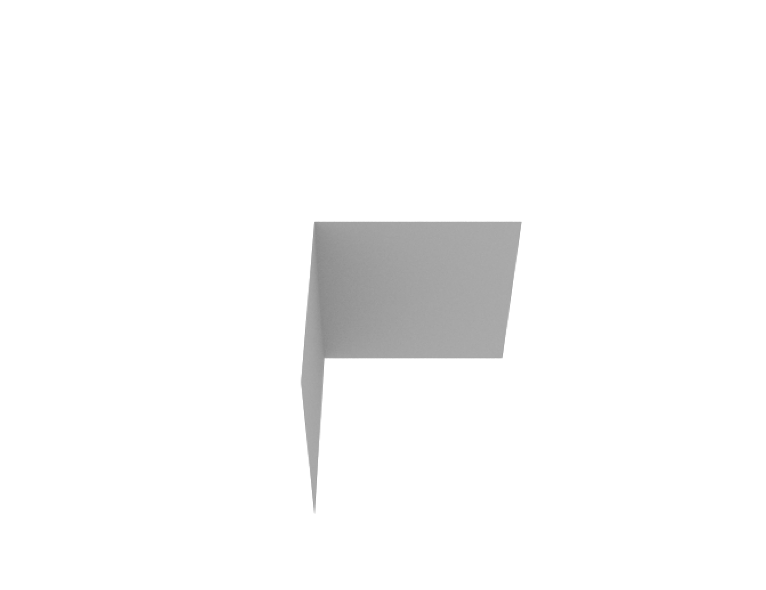

In [2]:
scene = load_scene(sionna.rt.scene.simple_wedge)

# Create new camera with different configuration
my_cam = Camera("my_cam", position=[10,-100,100], look_at=[10,0,0])
scene.add(my_cam)

if no_preview:
    # Render scene
    scene.render(my_cam);

In [3]:
%%skip_if no_preview
scene.preview()

The wedge has an opening angle of $\frac{3}{2}\pi=270^\circ$, i.e., $n=1.5$. The 0-face is aligned with the x axis and the n-face aligned with the negative y axis.

For the following experiments, we will configure the wedge to be made of metal, an almost perfect conductor, and set the frequency to 1GHz.

In [4]:
scene.frequency = 1e9 # 1GHz
scene.objects["wedge"].radio_material = "itu_metal" # Almost perfect reflector

With our scene being set-up, we now need to configure a transmitter and place multiple receivers to measure the field.
We assume that the transmitter and all receivers have a single vertically polarized isotropic antenna.

In [5]:
# Configure the antenna arrays used by the transmitters and receivers
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

scene.rx_array = scene.tx_array

In [6]:
# Transmitter
tx_angle = 30/180*PI # Angle phi from the 0-face
tx_dist = 50 # Distance from the edge
tx_pos = 50*r_hat(PI/2, tx_angle)
ref_boundary = (PI - tx_angle)/PI*180
los_boundary = (PI + tx_angle)/PI*180
scene.add(Transmitter(name="tx",
                      position=tx_pos,
                      orientation=[0,0,0]))

# Receivers
# We place num_rx receivers uniformly spaced on the segment of a circle around the wedge
num_rx = 1000 # Number of receivers
rx_dist = 5 # Distance from the edge
phi = tf.linspace(1e-2, 3/2*PI-1e-2, num=num_rx)
theta = PI/2*tf.ones_like(phi)
rx_pos = rx_dist*r_hat(theta, phi)

for i, pos in enumerate(rx_pos):
    scene.add(Receiver(name=f"rx-{i}",
                       position=pos,
                       orientation=[0,0,0]))

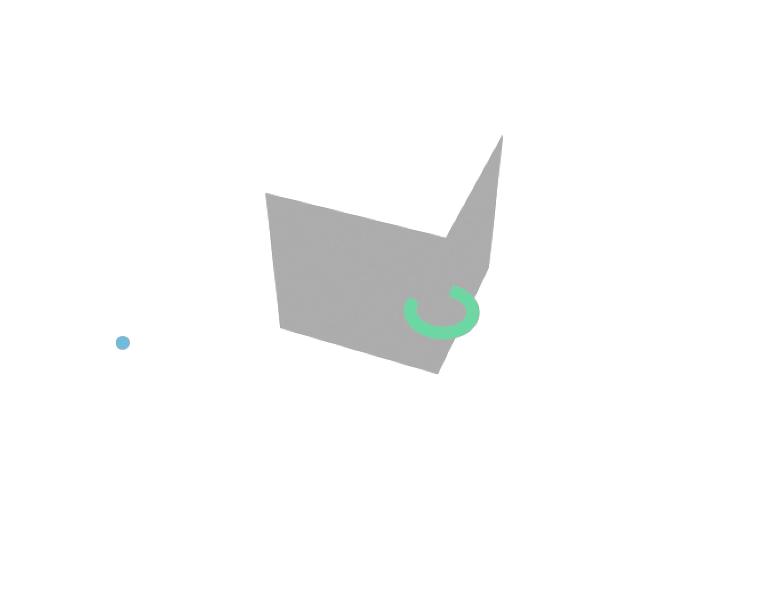

In [7]:
# Render scene
my_cam.position = [-30,100,100]
my_cam.look_at([10,0,0])
if no_preview:
    scene.render(my_cam);

In [8]:
%%skip_if no_preview
scene.preview()

In the above figure, the blue ball is the transmitter and the green circle corresponds to 1000 receivers uniformly distributed over a segment of a circle around the edge. 

Next, we compute the channel impulse response between the transmitter and all of the receivers. We deactivate scattering in this notebook as it would require a prohibitive amount of memory with such a large number of receivers.

In [9]:
# Compute paths between the transmitter and all receivers
paths = scene.compute_paths(num_samples=1e6,
                            los=True,
                            reflection=True,
                            diffraction=True,
                            scattering=False)

# Obtain channel impulse responses
# We squeeze irrelevant dimensions
# [num_rx, max_num_paths]
a, tau = [np.squeeze(t) for t in paths.cir()]

In [10]:
def compute_gain(a, tau):
        """Compute $|H(f)|^2 at f = 0 where H(f) is the baseband channel frequency response"""
        a = tf.squeeze(a, axis=-1)
        h_f_2 = tf.math.abs(tf.reduce_sum(a, axis=-1))**2
        h_f_2 = tf.where(h_f_2==0, 1e-24, h_f_2)
        g_db = 10*np.log10(h_f_2)
        return tf.squeeze(g_db)

Let's have a look at the channel impulse response of one of the receivers:

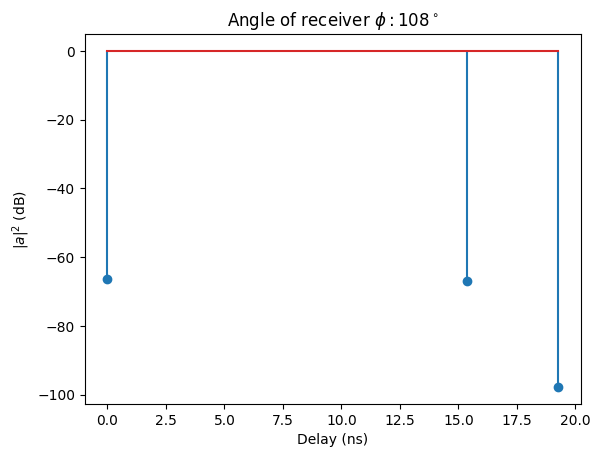

In [11]:
n = 400
plt.figure()
plt.stem(tau[n]/1e-9, 10*np.log10(np.abs(a[n])**2))
plt.title(f"Angle of receiver $\phi: {int(phi[n]/PI*180)}^\circ$");
plt.xlabel("Delay (ns)");
plt.ylabel("$|a|^2$ (dB)");

For an angle of around 108 degrees, the receiver is located within Region I, where all propagation effects should be visible.
As expected, we can observe three path: line-of-sight, reflected, and diffracted. While the first two have roughly the same strength (as metal is an almost perfect reflector), the diffracted path has significantly lower energy.

Next, let us compute the channel frequency response $H(f)$ as the sum of all paths multiplied with their complex phase factors: 

$$H(f) = \sum_{i=1}^N a_i e^{-j2\pi\tau_i f}$$

In [12]:
h_f_tot = np.sum(a, axis=-1)

We can now visualize the path gain $|H(f)|^2$ for all receivers, i.e., as a function of the angle $\phi$:

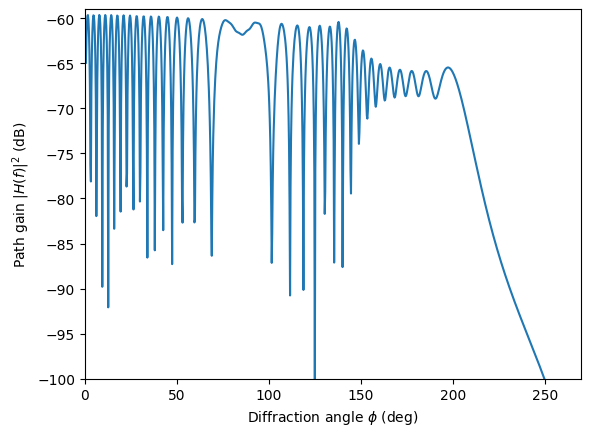

In [13]:
fig = plt.figure()
plt.plot(phi/PI*180, 20*np.log10(np.abs(h_f_tot)))
plt.xlabel("Diffraction angle $\phi$ (deg)");
plt.ylabel(r"Path gain $|H(f)|^2$ (dB)");
plt.ylim([-100, -59]);
plt.xlim([0, phi[-1]/PI*180]);

The most important observation from the figure above is that $H(f)$ remains continous over the entire range of $\phi$, especially at the RSB and ISB boundaries at around $\phi=150^\circ$ and $\phi=209^\circ$, respectively. 

To get some more insight, the convenience function in the next cell, computes and visualizes the different components of $H(f)$ by their type.

In [14]:
def plot(frequency, material):
    """Plots the path gain $|H(f)|^2 versus $phi$ for a given
       frequency and RadioMaterial of the wedge.
    """
    # Set carrier frequency and material of the wedge
    # You can see a list of available materials by executing
    # scene.radio_materials
    scene.frequency = frequency
    scene.objects["wedge"].radio_material = material
    
    # Recompute paths with the updated material and frequency
    paths = scene.compute_paths(num_samples=1e6,
                                los=True,
                                reflection=True,
                                diffraction=True,
                                scattering=False)
    
    def compute_gain(a, tau):
        """Compute $|H(f)|^2 are f = 0 where H(f) is the baseband channel frequency response"""
        a = tf.squeeze(a, axis=-1)
        h_f_2 = tf.math.abs(tf.reduce_sum(a, axis=-1))**2
        h_f_2 = tf.where(h_f_2==0, 1e-24, h_f_2)
        g_db = 10*np.log10(h_f_2)
        return tf.squeeze(g_db)
    
    # Compute gain for all path types
    g_tot_db = compute_gain(*paths.cir())
    g_los_db = compute_gain(*paths.cir(reflection=False, diffraction=False, scattering=False))
    g_ref_db = compute_gain(*paths.cir(los=False, diffraction=False, scattering=False))
    g_dif_db = compute_gain(*paths.cir(los=False, reflection=False, scattering=False))
    
    # Make a nice plot
    fig = plt.figure()
    phi_deg = phi/PI*180
    ymax = np.max(g_tot_db)+5
    ymin = ymax - 45
    plt.plot(phi_deg, g_tot_db)
    plt.plot(phi_deg, g_los_db)
    plt.plot(phi_deg, g_ref_db)
    plt.plot(phi_deg, g_dif_db)
    plt.ylim([ymin, ymax])
    plt.xlim([phi_deg[0], phi_deg[-1]]);
    plt.legend(["Total", "LoS", "Reflected", "Diffracted"], loc="lower left")
    plt.xlabel("Diffraction angle $\phi$ (deg)")
    plt.ylabel("Path gain $|H(f)|^2$ (dB)")
    ax = fig.axes[0]
    ax.axvline(x=ref_boundary, ymin=0, ymax=1, color="black", linestyle="--")
    ax.axvline(x=los_boundary, ymin=0, ymax=1, color="black", linestyle="--") 
    ax.text(ref_boundary-10,ymin+5,'RSB',rotation=90,va='top')
    ax.text(los_boundary-10,ymin+5,'ISB',rotation=90,va='top')
    ax.text(ref_boundary/2,ymax-2.5,'Region I', ha='center', va='center',
            bbox=dict(facecolor='none', edgecolor='black', pad=4.0))
    ax.text(los_boundary-(los_boundary-ref_boundary)/2,ymax-2.5,'Region II', ha='center', va='center',
            bbox=dict(facecolor='none', edgecolor='black', pad=4.0))
    ax.text(phi_deg[-1]-(phi_deg[-1]-los_boundary)/2,ymax-2.5,'Region III', ha='center', va='center',
            bbox=dict(facecolor='none', edgecolor='black', pad=4.0))
    plt.title('$f={}$ GHz ("{}")'.format(frequency/1e9, material))
    plt.tight_layout()
    return fig

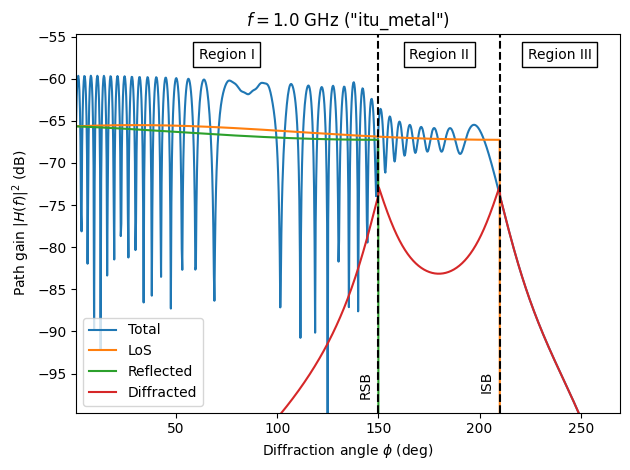

In [15]:
plot(1e9, "itu_metal");

The figure above shows the path gain for the total field as well as that for the different path types. In Region $I$, the line-of-sight and reflected paths dominate the total field. While their contributions are almost constant over the range of $\phi\in[0,150^\circ]$, their combined field exhibits large fluctutations due to constructive and destructive interference. As we approach the RSB, the diffracted field increases to ensure continuity at $\phi=150^\circ$, where the reflected field immediately drops to zero. A similar observation can be made close to the ISB, where the incident (or line-of-sight) component suddenly vanishes. In Region $III$, the only field contribution comes from the diffracted field.

Let us now have a look at what happens when we change the frequency to $10\,$GHz.

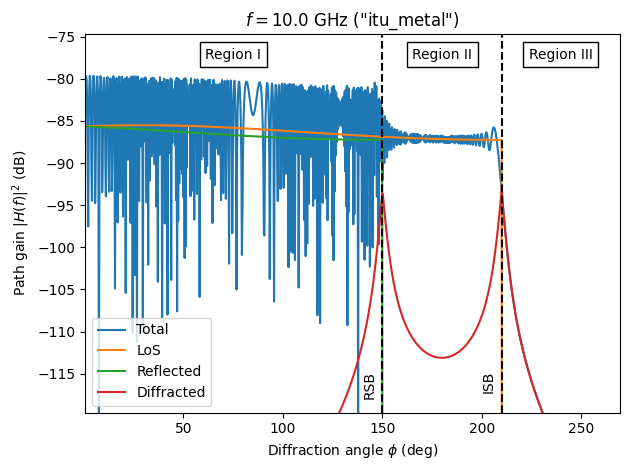

In [16]:
plot(10e9, "itu_metal");

The first observation we can make is that the overall path gain has dropped by around $20\,$dB. This is expected as it is proportional to the square of the wavelength $\lambda$.

The second noticeable difference is that the path gain fluctuates far more rapidly. This is simply due to the shorter wavelength.

The third observation we can make is that the diffracted field decays far more radpily when moving away from the boundaries as compared to a frequency of $1\,$GHz. Thus, diffraction is less important at high frequencies.

We can verify that the same trends continue by plotting the result for a frequency of $100\,$GHz, which is the upper limit for which the ITU Metal material is defined (see the [Sionna RT Documentation](https://nvlabs.github.io/sionna/api/rt.html#radio-materials)).

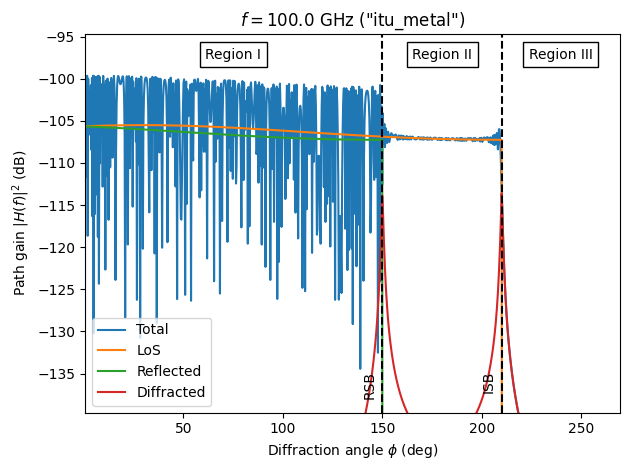

In [17]:
plot(100e9, "itu_metal");

It is also interesting to change the material of the wedge. The preconfigured materials in Sionna RT can be inspected with the following command:

In [18]:
list(scene.radio_materials.keys())

['vacuum',
 'itu_concrete',
 'itu_brick',
 'itu_plasterboard',
 'itu_wood',
 'itu_glass',
 'itu_ceiling_board',
 'itu_chipboard',
 'itu_plywood',
 'itu_marble',
 'itu_floorboard',
 'itu_metal',
 'itu_very_dry_ground',
 'itu_medium_dry_ground',
 'itu_wet_ground']

Let's see what happens when we change the material of the wedge to wood and the frequency back to $1\,$GHz.

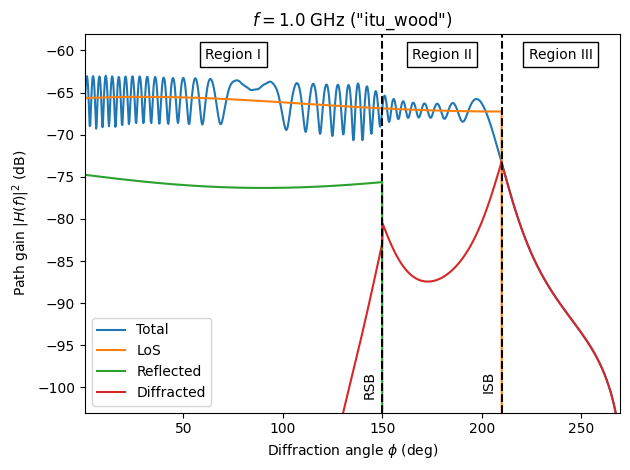

In [19]:
plot(1e9, "itu_wood");

We immediately notice that wood is a bad reflector since the strength of the reflected path has dropped by $10\,$dB compared to the metal. Thanks to the heuristic extension of the diffracted field equations in [2] to non-perfect conductors in [4] (which are implemented in Sionna RT), the total field remains continuous.

You might now want to try different materials and frequencies for yourself.

## Coverage Maps with Diffraction

So far, we have obtained a solid microscopic understanding of the effect of scattering. Let us now turn to the macroscopic effects that can be nicely observed through coverage maps.

A coverage map describes the average received power from a specific transmitter at every point on a plane. The effects of fast fading, i.e., constructive/destructive interference between different paths, are averaged out by summing the squared amplitudes of all paths. As we cannot compute coverage maps with infinitely fine resolution, they are approximated by small rectangular tiles for which average values are computed. For a detailed explanation, have a look at the [API Documentation](https://nvlabs.github.io/sionna/api/rt.html#coverage-map).
 
 
Let us now load a slightly more interesting scene containing a couple of rectangular buildings and add a transmitter. Note that we do not need to add any receivers to compute a coverage map.

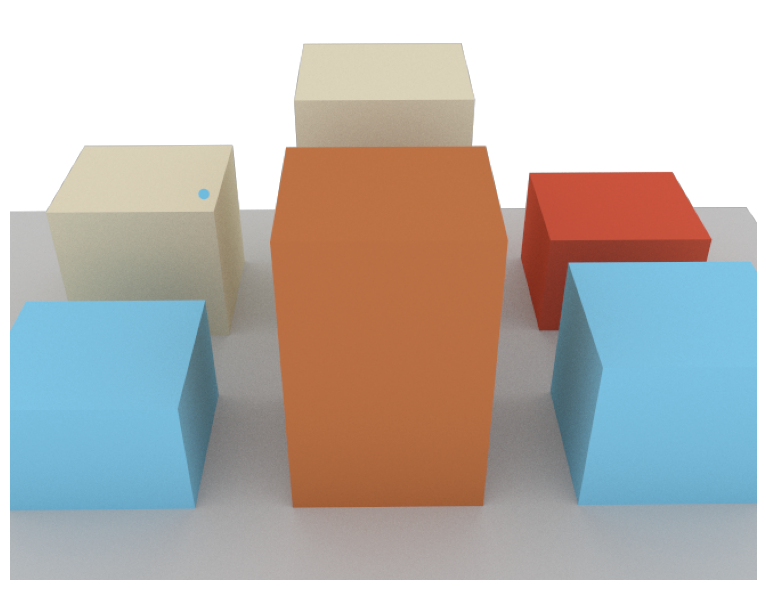

In [20]:
scene = load_scene(sionna.rt.scene.simple_street_canyon)

# Set the carrier frequency to 1GHz
scene.frequency = 1e9

scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

scene.rx_array = scene.tx_array

scene.add(Transmitter(name="tx",
                      position=[-33,11,32],
                      orientation=[0,0,0]))

# Render the scene from one of its cameras
# The blue dot represents the transmitter
if no_preview:
    scene.render('scene-cam-1');

In [21]:
%%skip_if no_preview
scene.preview()

Computing a coverage map is as simple as running the following command:

In [22]:
cm = scene.coverage_map(cm_cell_size=[1,1], num_samples=10e6)

We can visualizes the coverage map in the scene as follows:

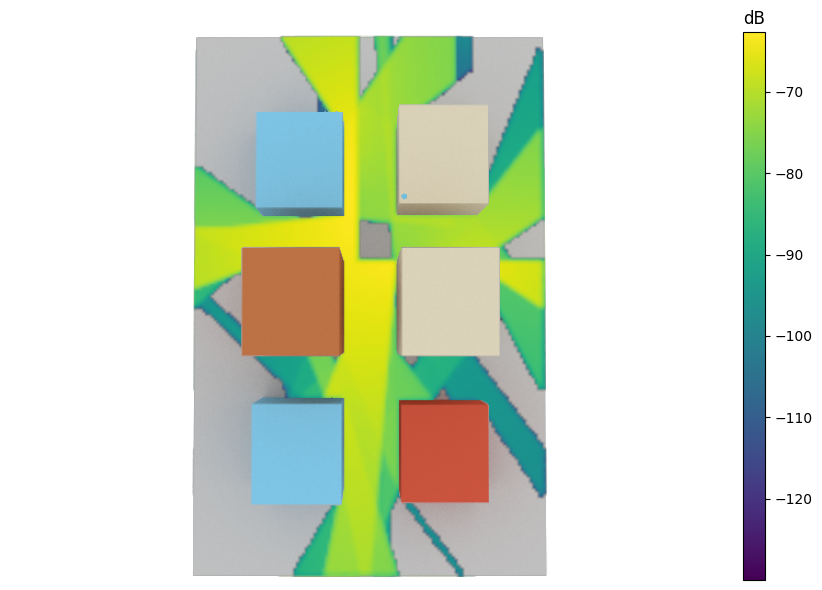

In [23]:
# Add a camera looking at the scene from the top
my_cam = Camera("my_cam", position=[10,0,300], look_at=[0,0,0])
my_cam.look_at([0,0,0])
scene.add(my_cam)

# Render scene with the new camera and overlay the coverage map
scene.render(my_cam, coverage_map=cm);

From the figure above, we can see that many regions behind buildings do not receive any signal. The reason for this is that diffraction is by default deactivated. Let us now generate a new coverage map with diffraction enabled:

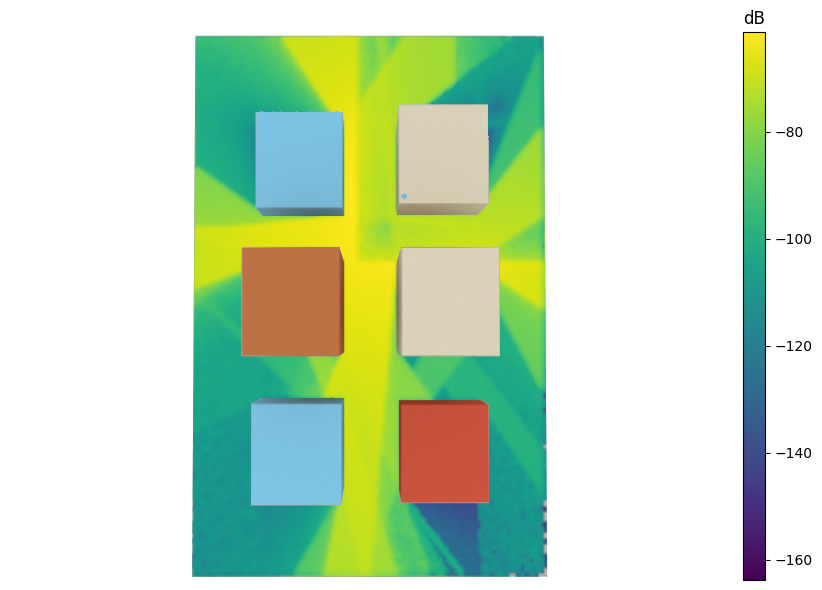

In [24]:
cm_diff = scene.coverage_map(cm_cell_size=[1,1], num_samples=10e6, diffraction=True)
scene.render(my_cam, coverage_map=cm_diff);

As expected from our experiements above, there is not a single point in the scene that is left blank. In some areas, however, the signal is still very weak and will not enable any form of communication.

Let's do the same experiments at a higher carrier frequency (30 GHz):

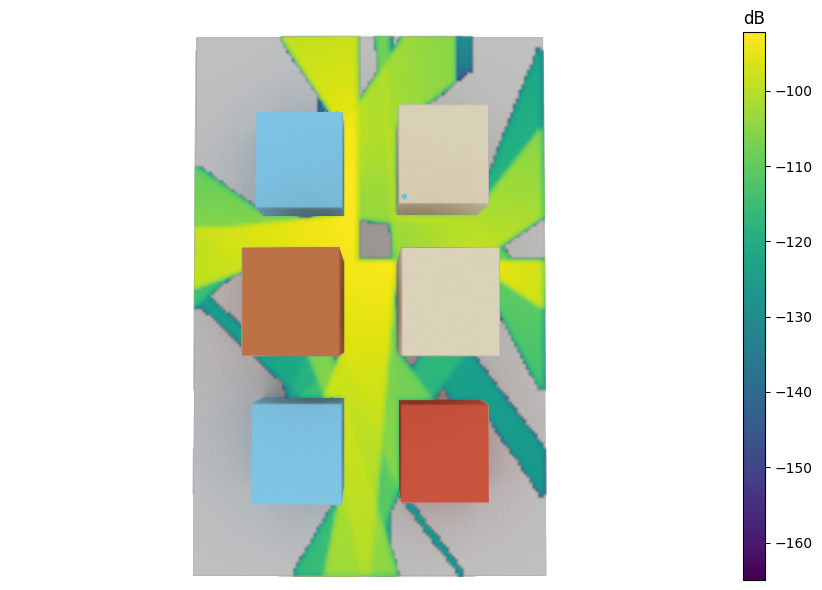

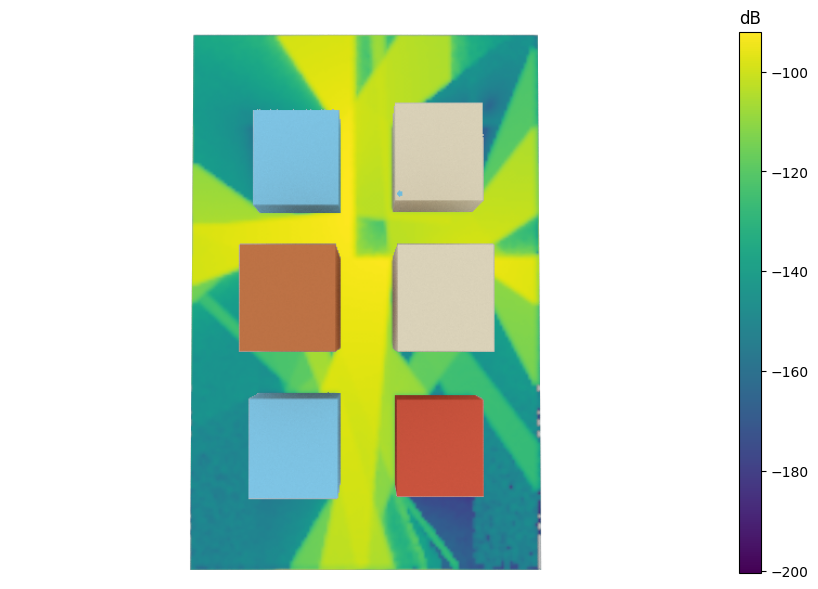

In [25]:
scene = load_scene(sionna.rt.scene.simple_street_canyon)
scene.frequency = 30e9
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

scene.rx_array = scene.tx_array
scene.add(Transmitter(name="tx",
                      position=[-33,11,32],
                      orientation=[0,0,0]))

scene.add(my_cam)

cm = scene.coverage_map(cm_cell_size=[1,1], num_samples=10e6)
cm_diff = scene.coverage_map(cm_cell_size=[1,1], num_samples=10e6, diffraction=True)
scene.render(my_cam, coverage_map=cm);
scene.render(my_cam, coverage_map=cm_diff);

While the 1 GHz and 30 GHz carrier frequency coverage maps appear similar, key differences exist. The dynamic range for 30 GHz has grown by around 16dB due to the reduced diffracted field in deep shadow areas, such as behind buildings. The diffracted field at this frequency is considerably smaller compared to the incident field than it is at 1 GHz, leading to a significant increase in dynamic range.

In conclusion, diffraction plays a vital role in maintaining the consistency of the electric field across both reflection and incident shadow boundaries. It generates diffracted rays that form a Keller cone around an edge. As we move away from these boundaries, the diffracted field diminishes rapidly. Importantly, the contributions of the diffracted field become less significant as the carrier frequency increases.

We hope you enjoyed our dive into diffraction with this Sionna RT tutorial. We really encourage you to get hands-on, conduct your own experiments and deepen your understanding of ray tracing. There's always more to learn, so do explore our other [tutorials](https://nvlabs.github.io/sionna/tutorials.html) as well.

## References
[1] J.B. Keller, [Geometrical Theory of Diffraction](https://opg.optica.org/josa/abstract.cfm?uri=josa-52-2-116), Journal of the Optical Society of America, vol. 52, no. 2, Feb. 1962.

[2] R.G. Kouyoumjian, [A uniform geometrical theory of diffraction for an edge in a perfectly conducting surface](https://ieeexplore.ieee.org/abstract/document/1451581/authors#authors), Proc. of the IEEE, vol. 62, no. 11, Nov. 1974.

[3] D.A. McNamara, C.W.I. Pistorius, J.A.G. Malherbe, [Introduction to the Uniform Geometrical Theory of Diffraction](https://us.artechhouse.com/Introduction-to-the-Uniform-Geometrical-Theory-of-Diffraction-P288.aspx), Artech House, 1990.

[4] R. Luebbers, [Finite conductivity uniform GTD versus knife edge diffraction in prediction of propagation path loss](https://ieeexplore.ieee.org/abstract/document/1143189), IEEE Trans. Antennas and Propagation, vol. 32, no. 1, Jan. 1984.